# Example Aoristic Analysis

[*Andrew Wheeler*](https://crimede-coder.com/)

This analysis shows off the functions to conduct [aoristic analysis of crime data](https://www.jratcliffe.net/aoristic-analysis) with unknown time intervals. The method was developed by Jerry Ratcliffe (see the above link for a nice breakdown).

In [1]:
import aoristic
import pandas as pd
import matplotlib.pyplot as plt

# Dallas crime data
df = pd.read_csv(f'dallasdata.csv.zip')
df['begin'] = pd.to_datetime(df['begin'])
df['end'] = pd.to_datetime(df['end'])

# These are my NIBRS and location labels
# in this data for reference

nibr_num = {'LARCENY/ THEFT OFFENSES': 0, 
            'MOTOR VEHICLE THEFT': 1, 
            'DESTRUCTION/ DAMAGE/ VANDALISM OF PROPERTY': 2, 
            'ASSAULT OFFENSES': 3, 
            'DRUG/ NARCOTIC VIOLATIONS': 4, 
            'BURGLARY/ BREAKING & ENTERING': 5, 
            'ALL OTHER OFFENSES': 6, 
            'TRAFFIC VIOLATION - HAZARDOUS': 7, 
            'ROBBERY': 8, 
            'PUBLIC INTOXICATION': 9, 
            'WEAPON LAW VIOLATIONS': 10, 
            'FRAUD OFFENSES': 11, 
            'DRIVING UNDER THE INFLUENCE': 12, 
            'TRESPASS OF REAL PROPERTY': 13, 
            'FAMILY OFFENSES, NONVIOLENT': 14, 
            'STOLEN PROPERTY OFFENSES': 15, 
            'EMBEZZELMENT': 16, 
            'COUNTERFEITING / FORGERY': 17}

loc_label = {0: 'Street',
             1: 'Apartment/Residence',
             2: 'Bar/Restaurant',
             3: 'Commercial',
             4: 'Gas/Convenience',
             5: 'Hotel/Motel',
             6: 'Other',
             7: 'Outdoor',
             8: 'Parking Lot',
             9: 'Store',
            10: 'School'}

In [2]:
# Lets do analysis of burglaries
burg = df[df['nibrs_cat'] == 5].copy()
burg['Type'] = (1*(burg['location'] == 1)).replace({1: 'Residential', 0: 'Commercial'})
print(burg['Type'].value_counts())
burg_aor = aoristic.agg_weekhour(burg,'begin','end',group=['Type'])

# can see that this generates hour by day of week by group in the data
burg_aor

Residential    10424
Commercial      8754
Name: Type, dtype: int64


,Type,weight,weekday,hour
0,Commercial,72.926611,0,0
1,Commercial,95.196473,0,1
2,Commercial,129.064980,0,2
3,Commercial,150.222895,0,3
4,Commercial,146.001093,0,4
...,...,...,...,...
331,Residential,60.245929,6,19
332,Residential,59.169821,6,20
333,Residential,69.536057,6,21
334,Residential,55.535867,6,22


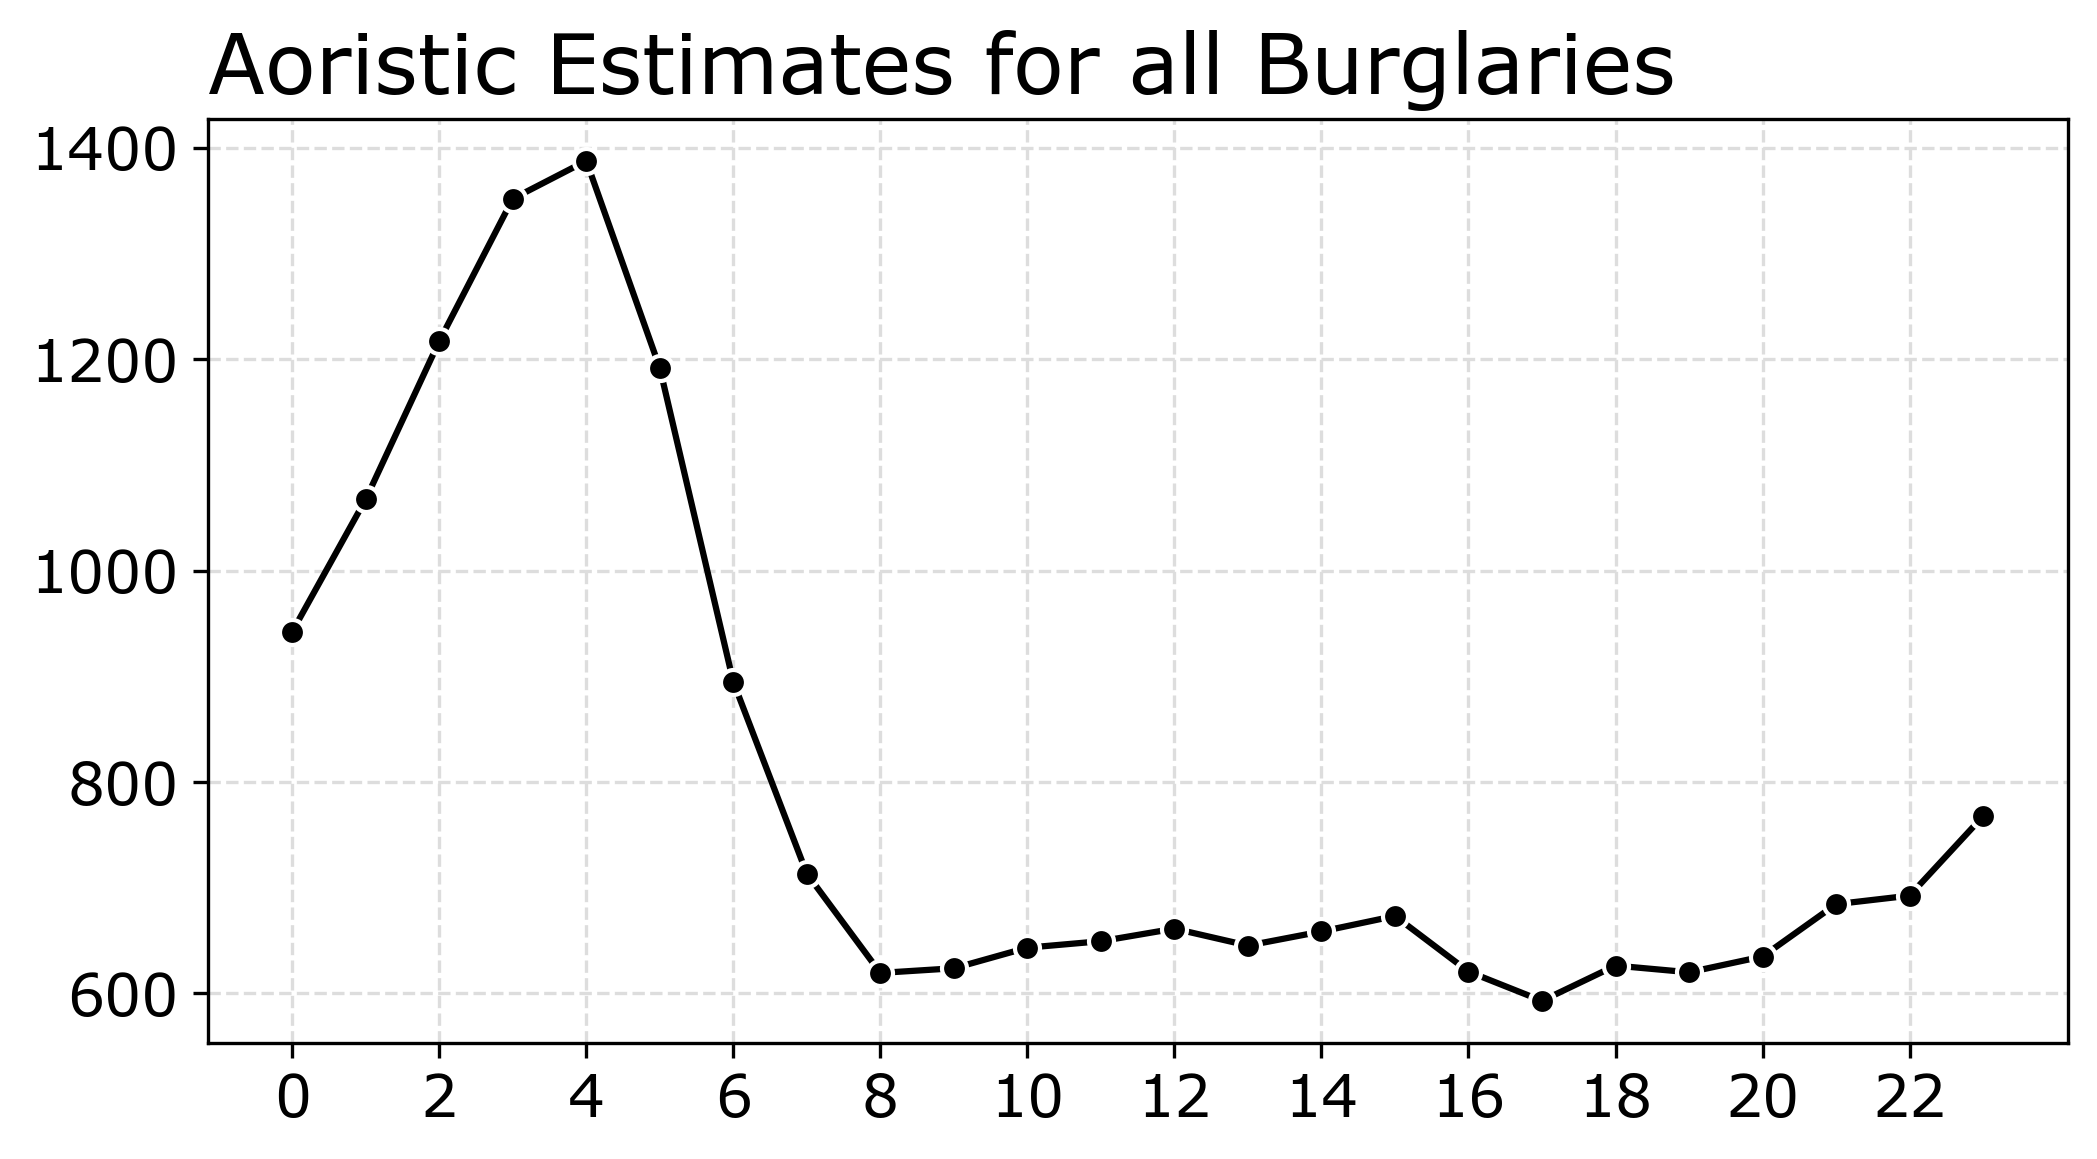

In [3]:
# Now have some helpers

# combining all of the data into just hour of day
b_hour = burg_aor.groupby('hour',as_index=False)['weight'].sum()

# in notebooks, you don't want to use fig.show, so I have show=False here
aoristic.plt_basic(b_hour,show=False,title='Aoristic Estimates for all Burglaries')

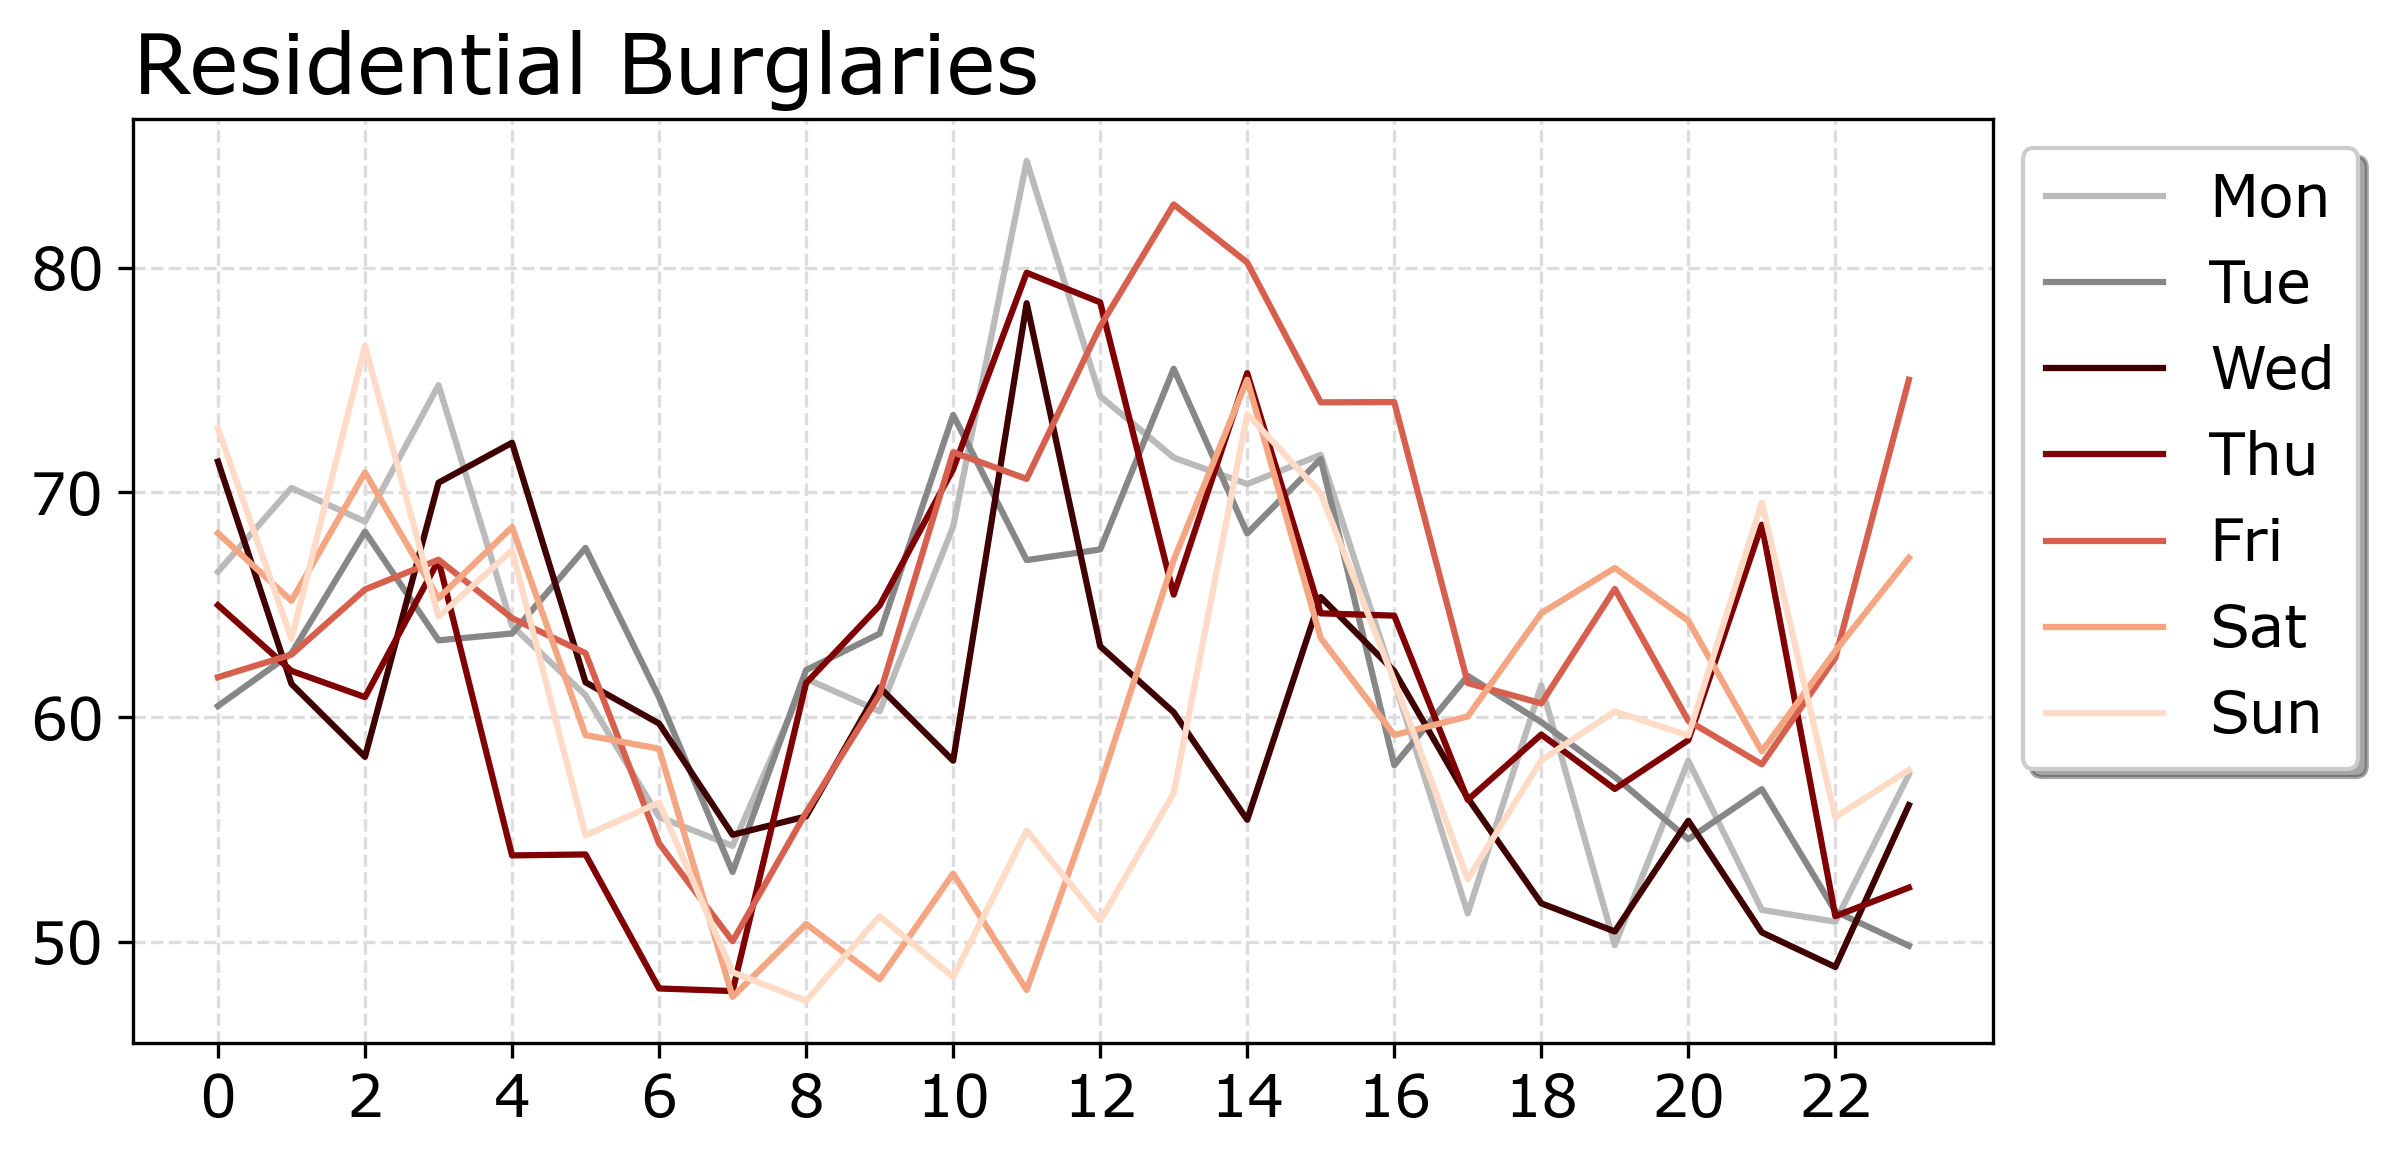

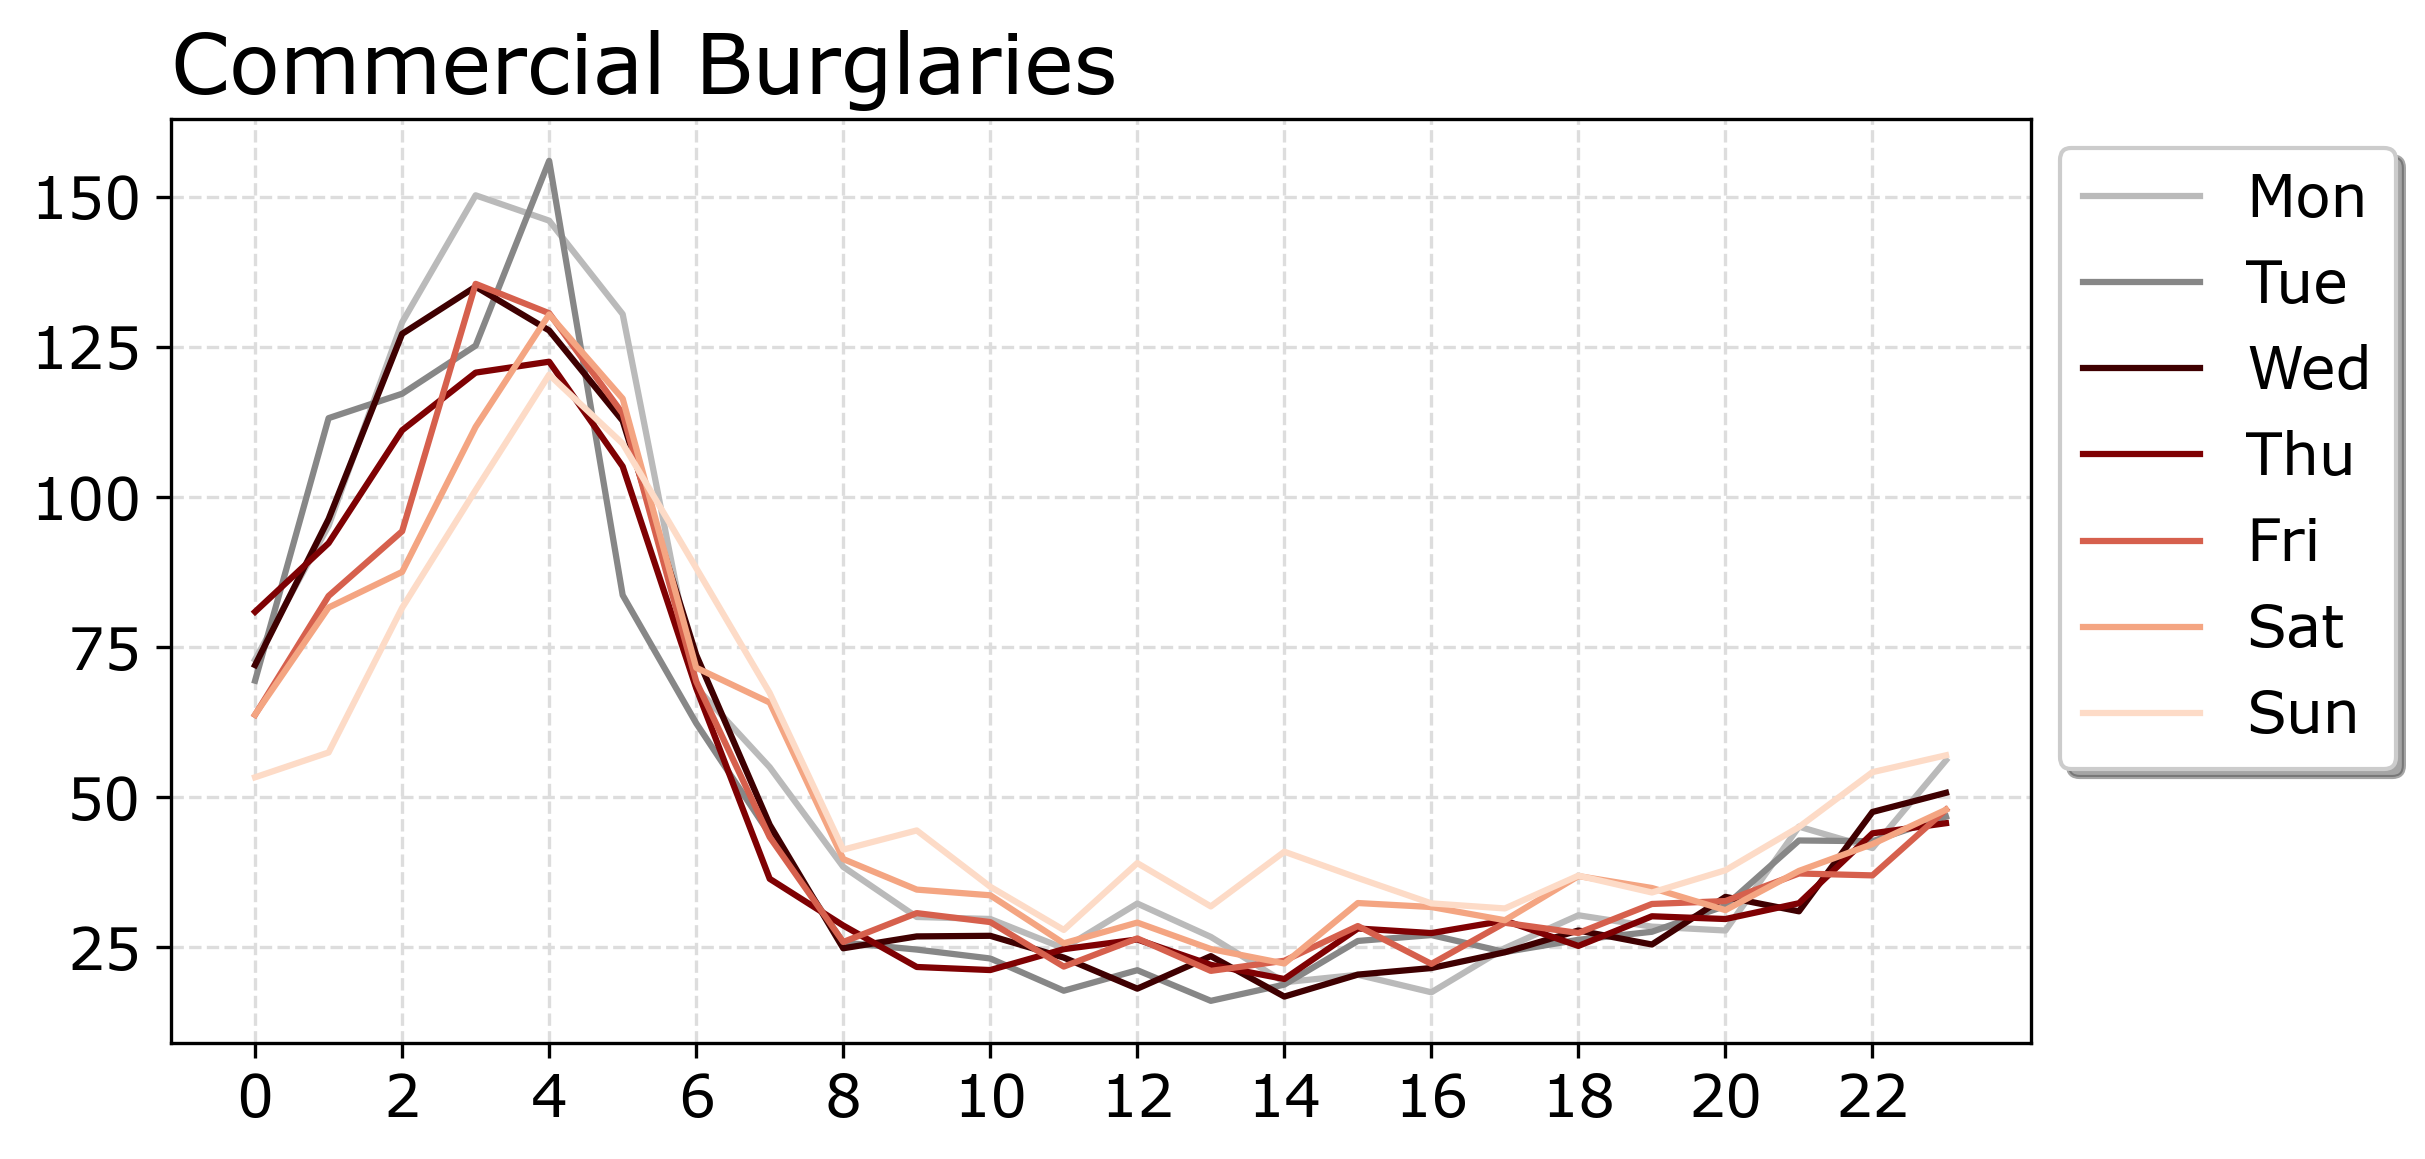

In [4]:
burg_comm = burg_aor[burg_aor['Type'] == 'Commercial'].copy()
burg_resi = burg_aor[burg_aor['Type'] == 'Residential'].copy()

# Can see the pattern is much different for residential!
# Sat/Sun is shifted slightly later in the day
aoristic.plt_super(burg_resi,show=False,title='Residential Burglaries')
aoristic.plt_super(burg_comm,show=False,title='Commercial Burglaries')

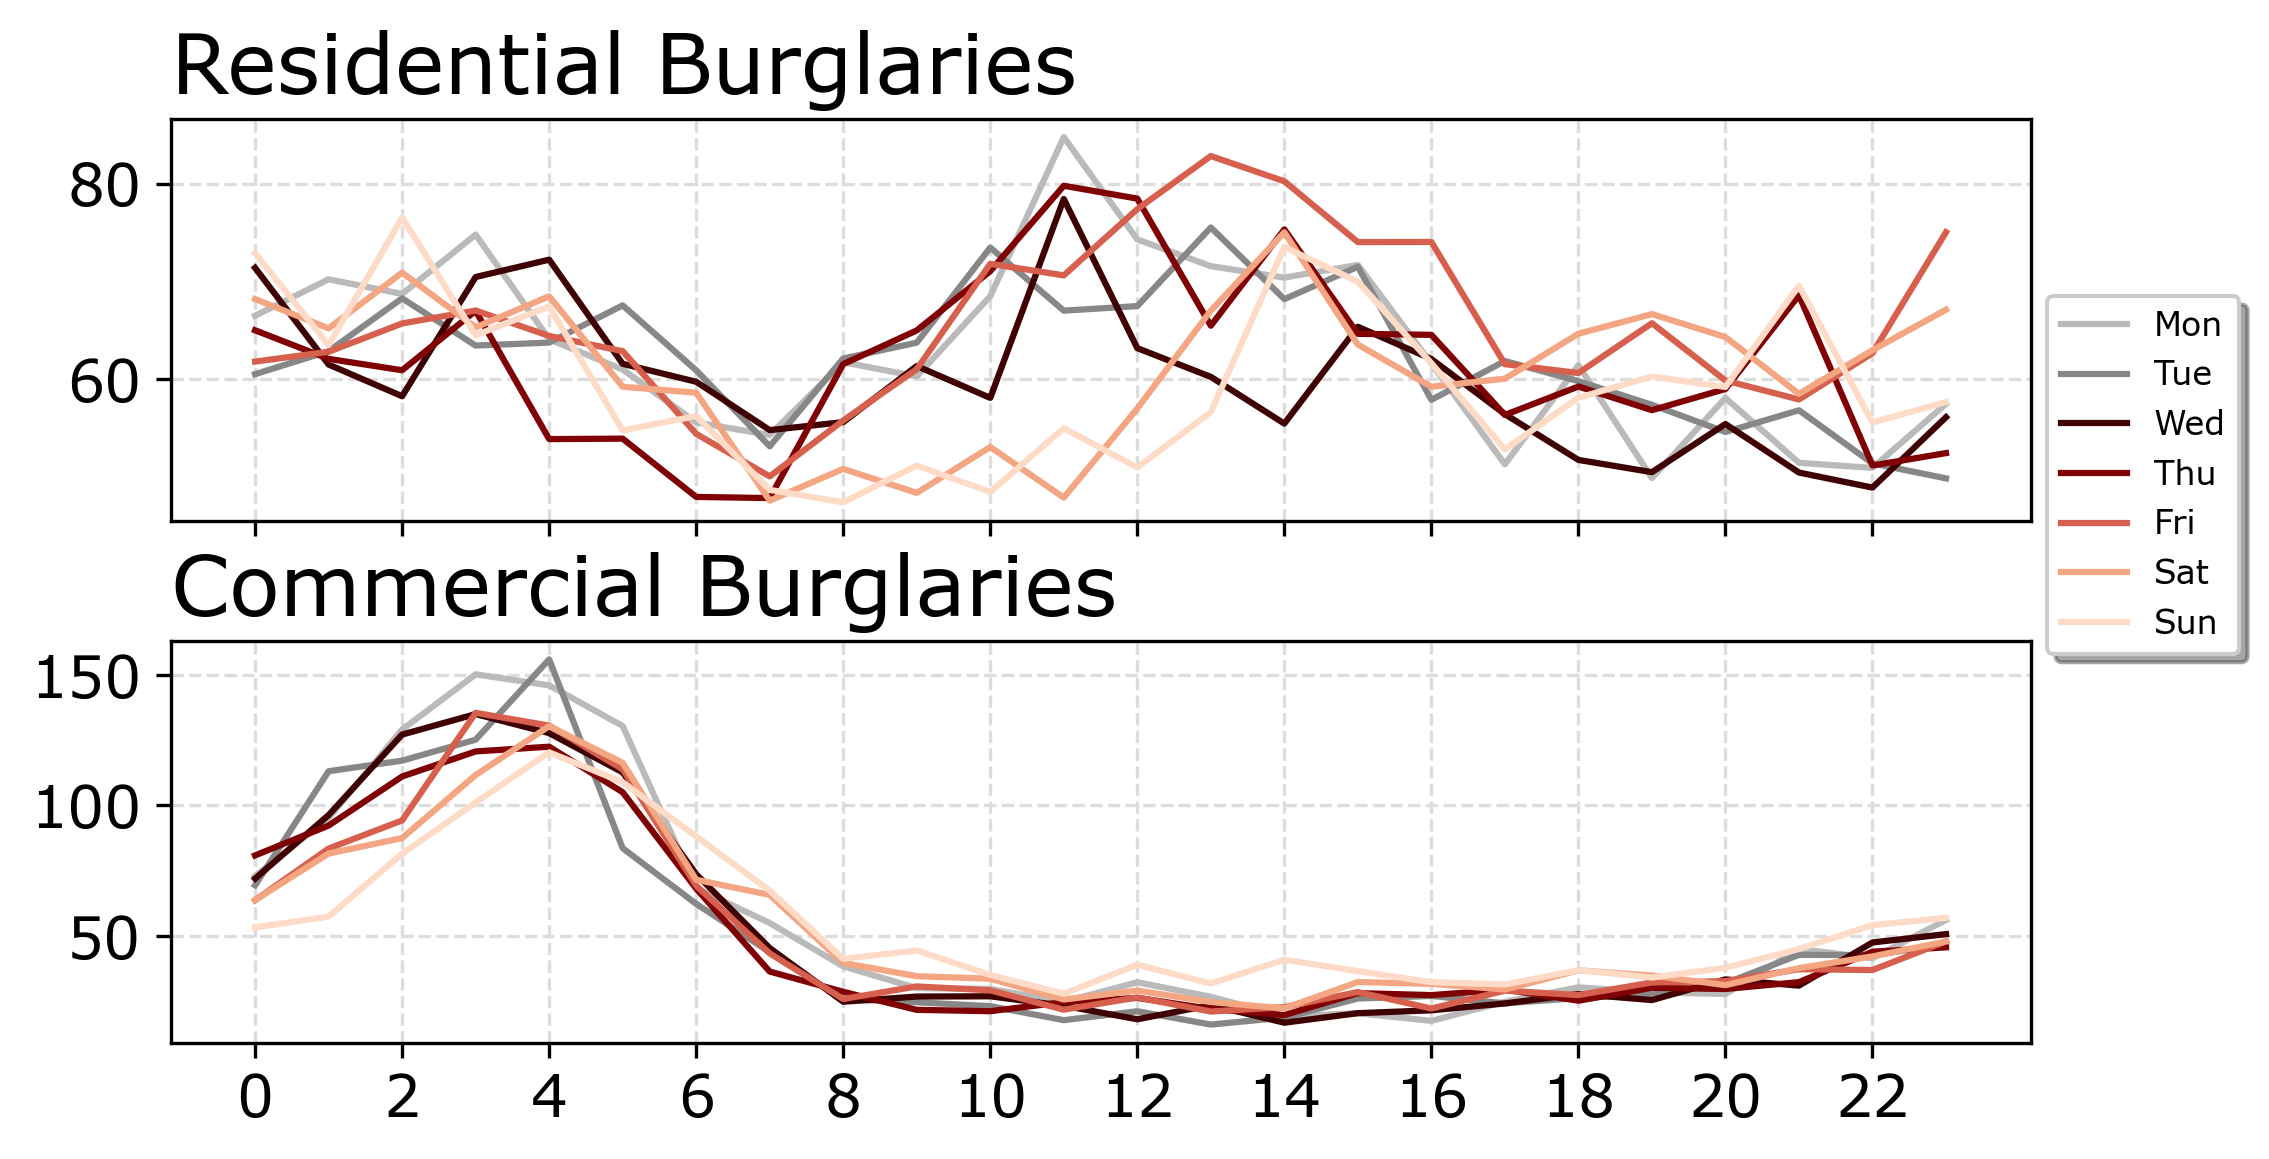

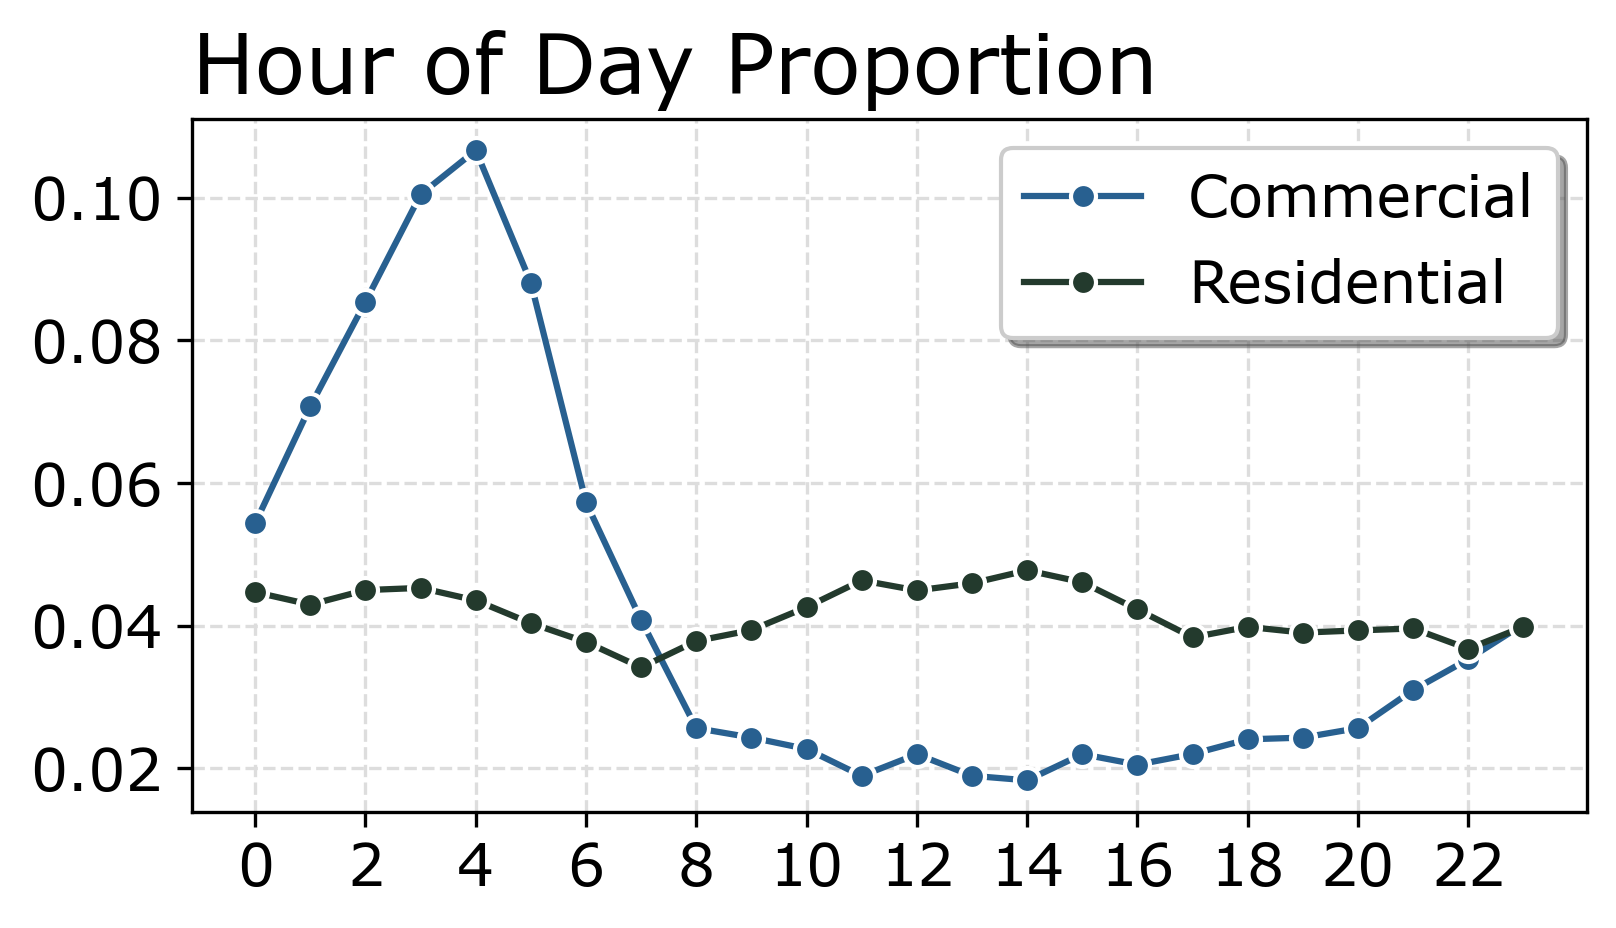

In [5]:
# These functions have helpers to just pass in ax

# Small multiple sharing X
fig, ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
lg = {'bbox_to_anchor':(1.0,0.6), 'fontsize': 8} # legend kwargs
aoristic.plt_super(burg_resi,ax=ax[0],show=False,title='Residential Burglaries',leg_kwargs=lg)
aoristic.plt_super(burg_comm,ax=ax[1],show=False,legend=False,title='Commercial Burglaries')
plt.subplots_adjust(hspace=0.3) # adjusting space between subplots

# Superimposing on the same plot and normalizing to percentages
bc_hour = burg_comm.groupby('hour',as_index=False)['weight'].sum()
bc_hour['weight'] = bc_hour['weight']/bc_hour['weight'].sum()
br_hour = burg_resi.groupby('hour',as_index=False)['weight'].sum()
br_hour['weight'] = br_hour['weight']/br_hour['weight'].sum()

fig, ax = plt.subplots(figsize=(6,3))
aoristic.plt_basic(bc_hour,show=False,ax=ax,color="#286090",label='Commercial',title='Hour of Day Proportion')
aoristic.plt_basic(br_hour,show=False,ax=ax,color="#233A2D",label='Residential')
lr = ax.legend() # assigning object just so don't get annoying output in notebook!

In [6]:
# Lets look at MV Thefts, since that has been surging
mv = df[df['nibrs_cat'] == 1].copy()

time_dif = mv['end'] - mv['begin']
print('Distribution of time differences in hours')
print( (time_dif.dt.seconds/(60*60)).describe()) # convert to hours
prop_uncertain = (time_dif.dt.seconds > 0).mean()
print(f'\nProportion of MV Thefts with unknown time {prop_uncertain:.2f}')

mv_aor = aoristic.agg_weekhour(mv,'begin','end') # it takes a bit to churn though 90,000+ rows

Distribution of time differences in hours
count    90448.000000
mean         6.471129
std          6.331465
min          0.000000
25%          0.500000
50%          4.500000
75%         11.000000
max         23.983333
dtype: float64

Proportion of MV Thefts with unknown time 0.92


C:\Users\andre\AppData\Local\Temp\ipykernel_2152\3712976951.py:6: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(f'Dallas PD Open Data', xy=(0, -0.19),


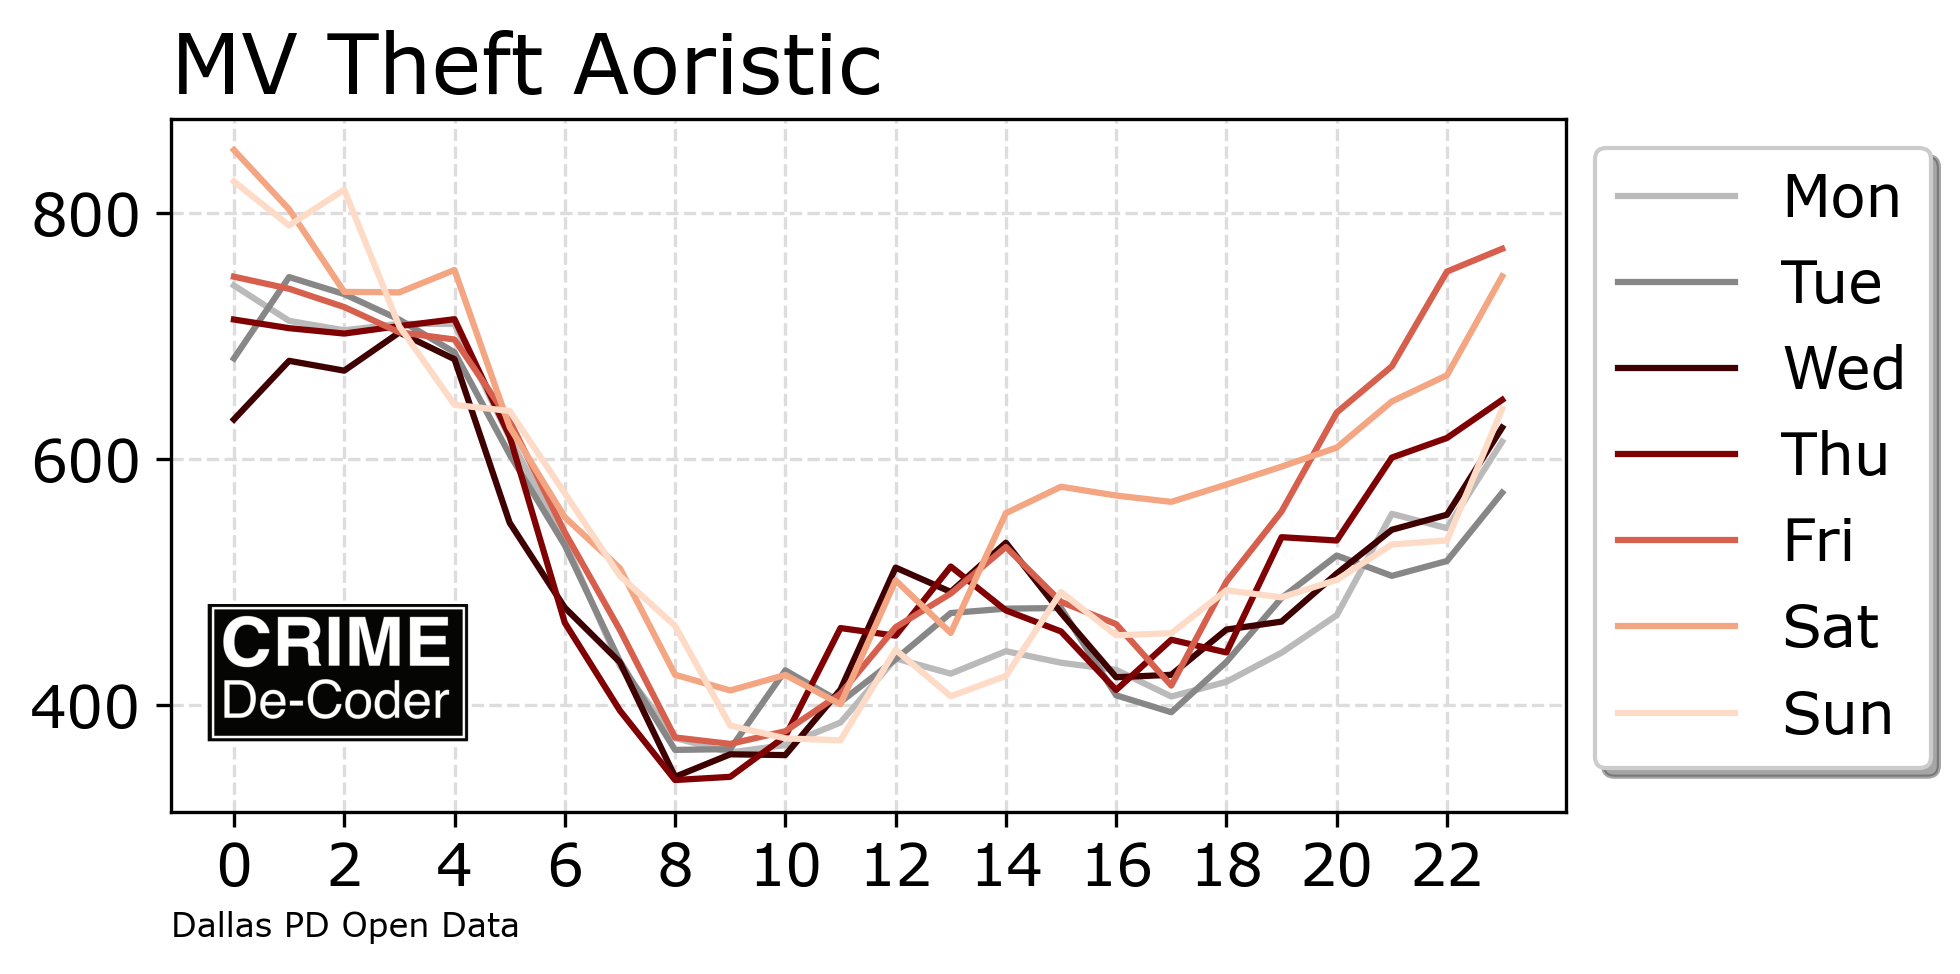

In [7]:
# Lets make a nice image to share in social media for blog post

fig, ax = plt.subplots(figsize=(6,3))
aoristic.plt_super(mv_aor,show=False,ax=ax,title='MV Theft Aoristic')
aoristic.add_logo(ax, loc=[0.02,0.1])
ax.annotate(f'Dallas PD Open Data', xy=(0, -0.19),
            xycoords='axes fraction', textcoords='offset points',
            size=8, ha='left', va='bottom')
fig.savefig('MVTheft_Aoristic.png',dpi=500,bbox_inches='tight')

C:\Users\andre\AppData\Local\Temp\ipykernel_2152\959087155.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("PuRd", 5)


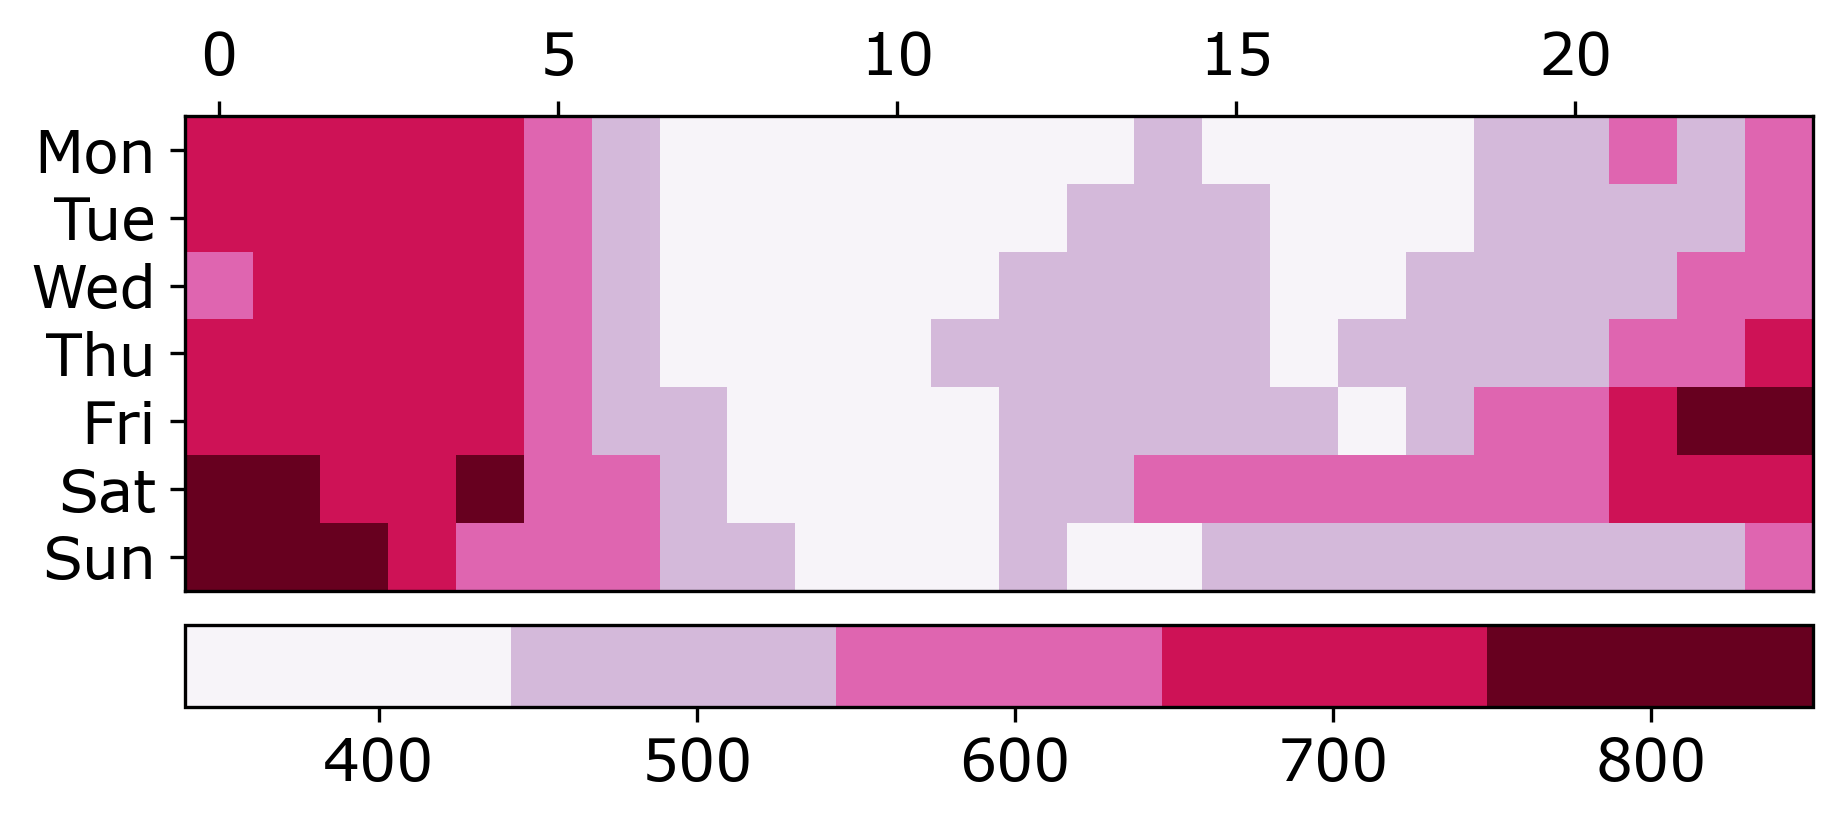

In [8]:
# If you must, here is how to make a heatmap style plot
from pylab import cm

# using a discrete colormap is easier to viz than continuous IMO
cmap = cm.get_cmap("PuRd", 5)

# pivot the table to wide format
mvp = mv_aor.pivot(index='weekday',columns='hour',values='weight')

fig, ax = plt.subplots(figsize=(7,3))
ax.tick_params(top=True,labeltop=True, bottom=False, labelbottom=False)
im = ax.imshow(mvp,cmap=cmap)
cbar = ax.figure.colorbar(im,ax=ax,location='bottom',pad=0.05)
ax.set_yticks(mvp.index,labels=aoristic.wd_lab)
ax.grid(False)

# Additional Notes

For several other additional resources I have made over the years

 - An [excel spreadsheet to conduct aoristic analysis](https://andrewpwheeler.com/2018/09/03/aoristic-analysis-for-hour-of-day-and-day-of-week-in-excel/)
 - A [SPSS macro to conduct aoristic analysis](https://dl.dropboxusercontent.com/s/56ukuqfpl12a7nt/aoristicMACRO_V2.sps?dl=0) (similar to here, can do by groups)